In [21]:
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch

import matplotlib.pyplot as plt
%matplotlib inline


In [22]:
model_path = "/tmp/model.ckpt"
model_path = "/tmp/AHHHHHH/model.ckpt"
# model_path = "../../checkpoints/model_v2_normalized.pth"
# image_path = "/media/disk1/lfainsin/2022_PARIS1/DSC_1387.jpg"
image_path = "/tmp/IMG_20220907_133915.jpg"
# image_path = "/tmp/10654661.webp"
gt_path = "/media/disk1/lfainsin/2022_PARIS1/MASK.PNG"


# Load image

(4032, 3024)


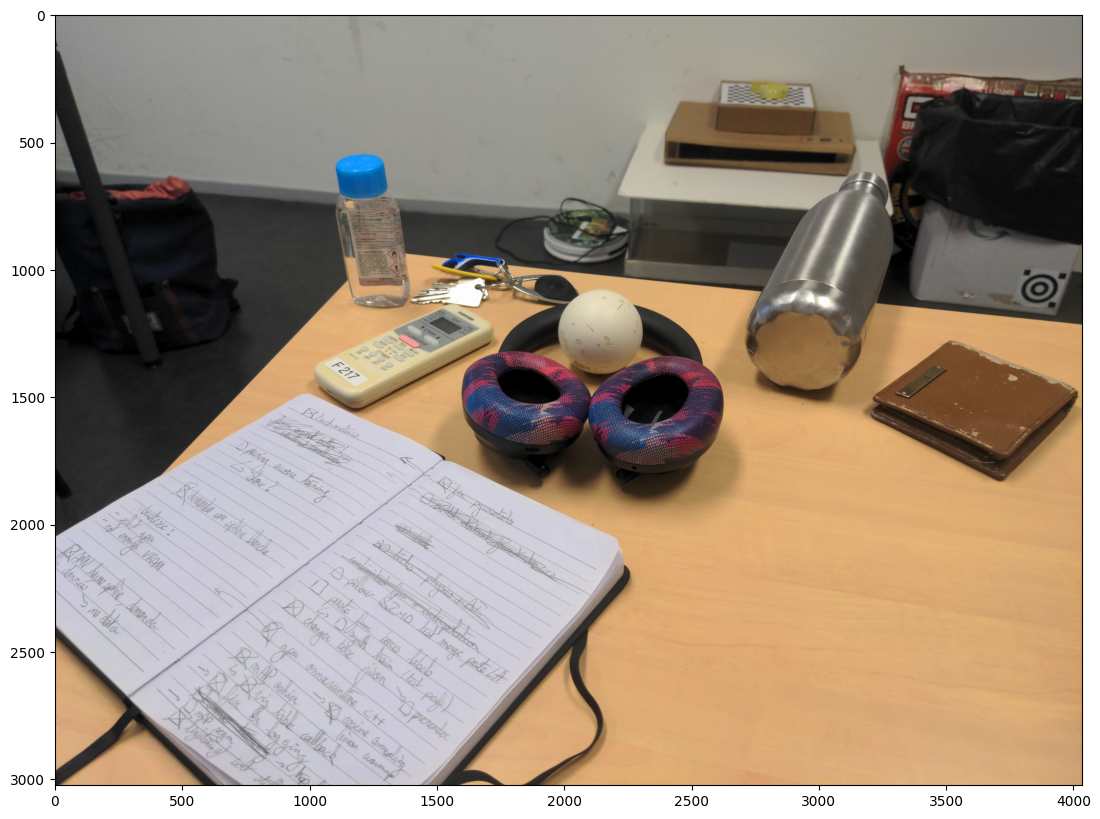

In [23]:
image = Image.open(image_path).convert("RGB")

plt.figure(figsize=(25, 10))
plt.imshow(image)

print(image.size)


# Inference

In [24]:
transform = A.Compose(
    [
        # A.LongestMaxSize(max_size=1024),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255,
        ),  # [0, 255] -> [0.0, 1.0] normalized
        ToTensorV2(),  # HWC -> CHW
    ],
)
aug = transform(image=np.asarray(image))
img = aug["image"]

img = img.unsqueeze(0)  # -> 1CHW


In [25]:
from mrcnn.module import MRCNNModule

net = MRCNNModule(2)

net.load_state_dict(torch.load(model_path)["state_dict"])

net.eval()
test = net.model(img)

print("nb masques detectés:", len(test[0]["masks"]))

print()
print(test)


nb masques detectés: 5

[{'boxes': tensor([[1975.3809, 1077.6555, 2307.4526, 1414.3323],
        [2723.0581,  643.3114, 3315.2222, 1472.3346],
        [1092.4521,  542.2773, 1357.1842, 1126.8506],
        [3211.8042, 1239.1320, 4012.0469, 1815.1863],
        [1089.5594,  525.7091, 1307.5491,  714.7249]],
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1, 1]), 'scores': tensor([0.9879, 0.8963, 0.1651, 0.1346, 0.0981], grad_fn=<IndexBackward0>), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0

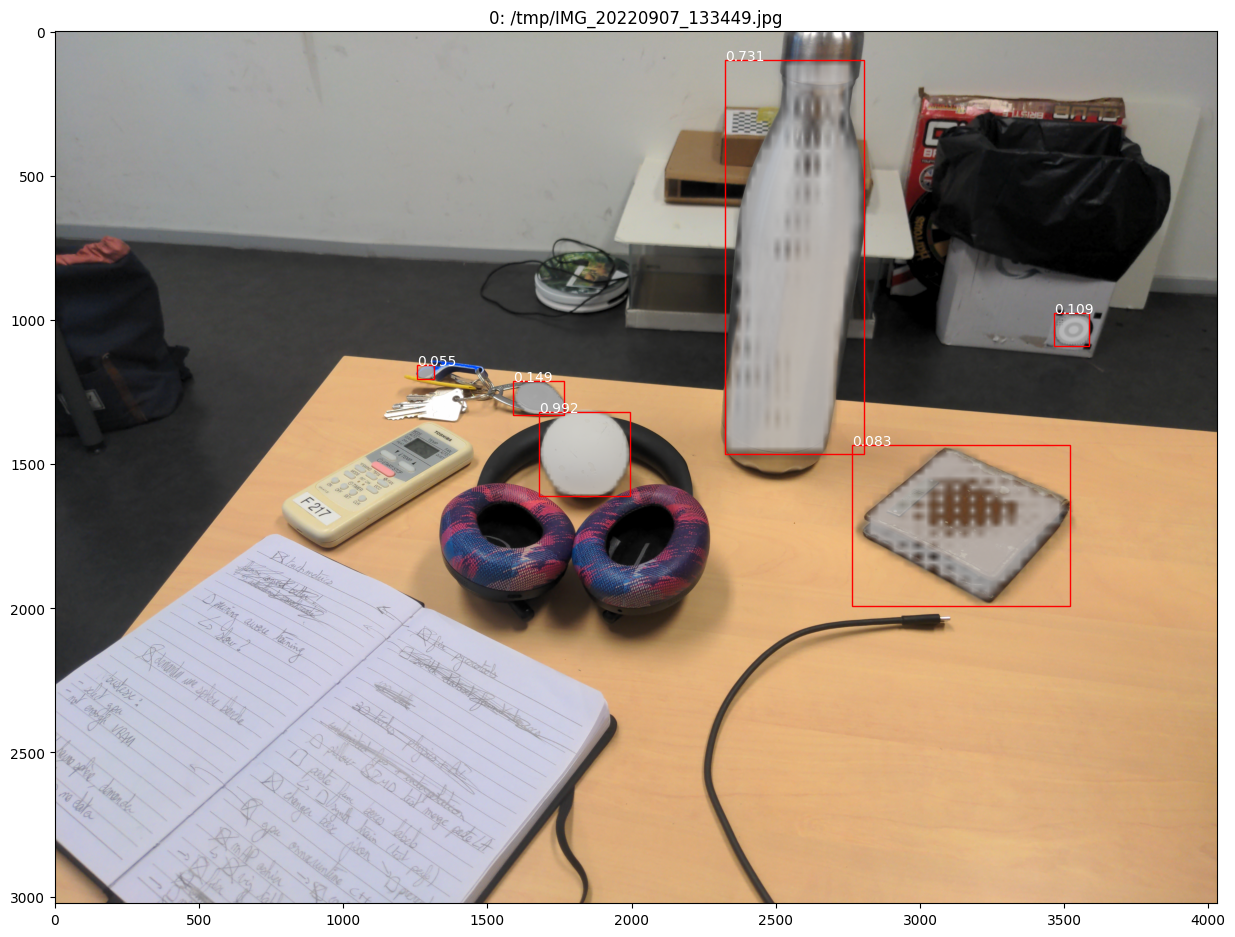

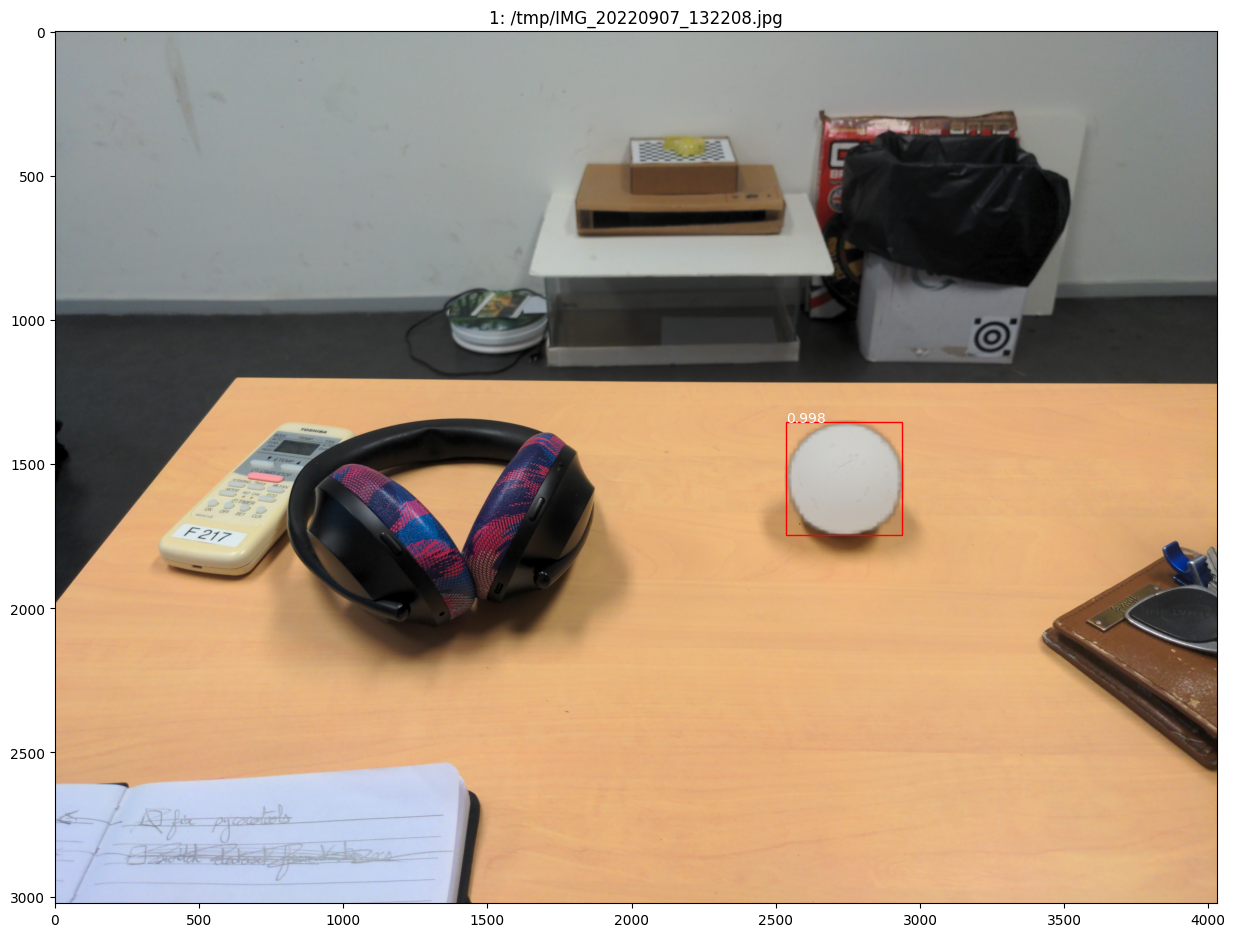

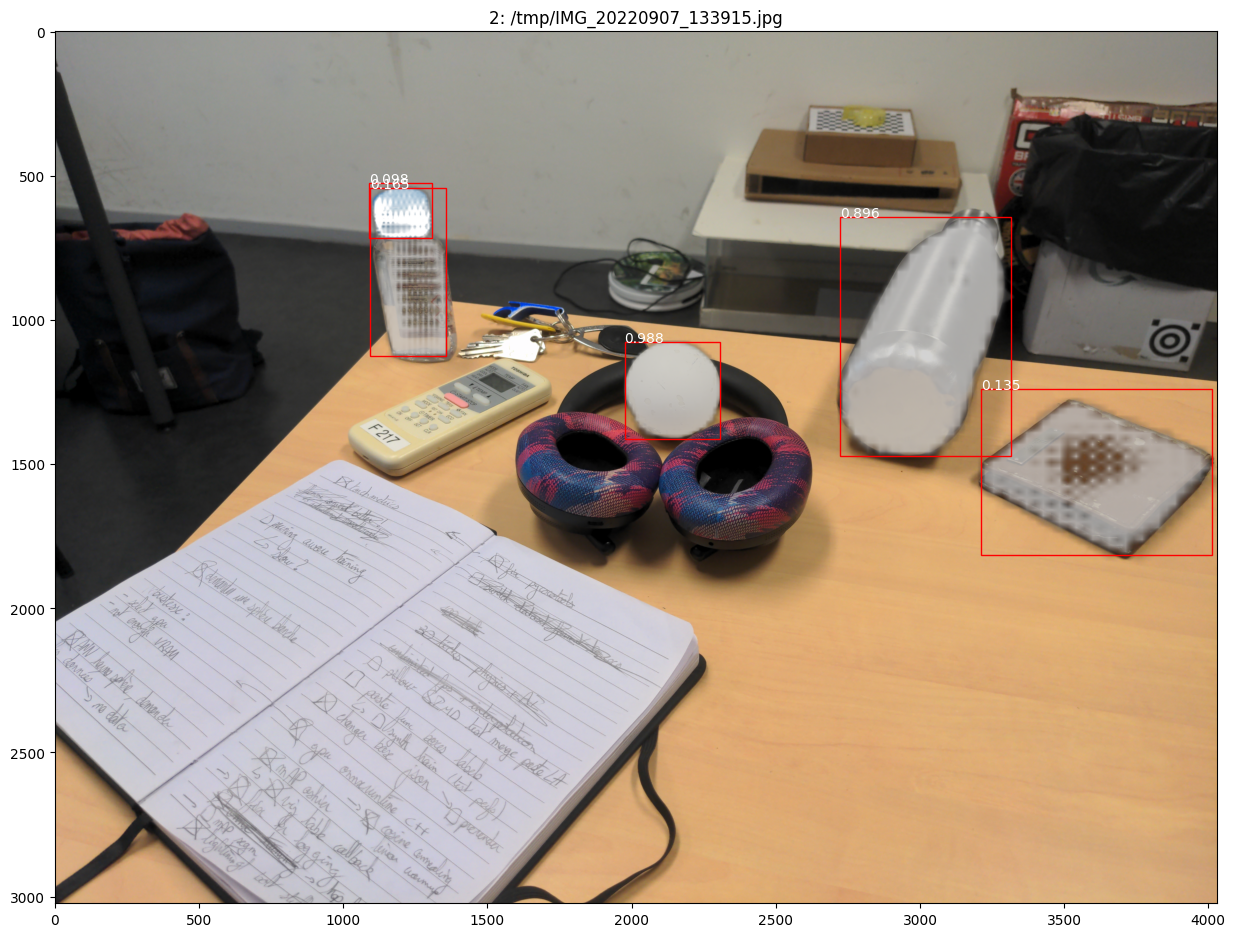

In [27]:
images_path = "/tmp/"
# images_path = "/media/disk1/lfainsin/2022_PARIS1/"

import matplotlib.patches as patches
import pathlib

images_files = list(pathlib.Path(images_path).glob("*.jpg"))

masks = []


for j, image_file in enumerate(images_files[:10]):
    spheres = []
    print(j + 1, "/", len(images_files), end="\r")
    image = Image.open(image_file).convert("RGB")

    aug = transform(image=np.asarray(image))
    img = aug["image"]
    img = img.unsqueeze(0)

    outputs = net.model(img)

    n = len(outputs[0]["masks"])
    mask = torch.zeros(outputs[0]["masks"][0].shape)
    bboxes = list(outputs[0]["boxes"])
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))

    for i in range(n):

        if outputs[0]["scores"][i] > 0:

            mask += outputs[0]["masks"][i]
            boxe = bboxes[i].detach().numpy()
            rect = patches.Rectangle(
                (boxe[0], boxe[1]), boxe[2] - boxe[0], boxe[3] - boxe[1], linewidth=1, edgecolor="r", facecolor="none"
            )
            ax.text(boxe[0], boxe[1], f"{outputs[0]['scores'][i]:.03f}", color="white")
            ax.add_patch(rect)

            r = min(boxe[3] - boxe[1], boxe[2] - boxe[0]) / 2
            x = boxe[0] + r - image.width / 2
            y = boxe[0] + r - image.height / 2
            spheres.append({
                "x": x,
                "y": y,
                "r": r,
            })

    plt.title(f"{j}: {image_file}")
    mask = mask.detach().squeeze(0).numpy() * 200
    mask = Image.fromarray(mask).convert("L")
    image.paste(mask, (0, 0), mask)

    plt.subplot(1, 1, 1)
    plt.imshow(image)

    # print(spheres)
